<a href="https://colab.research.google.com/github/dprohor/timeseries2/blob/main/diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проектная работа

Название проектной работы: Прогнозирование количества аварийных событий по вине персонала.

In [ ]:
# установка дополнительной библиотеки
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


In [ ]:
!pip install tsfresh -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler


# from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import norm

from prophet import Prophet



# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import smape_loss



import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)


from sklearn.metrics import (accuracy_score, mean_squared_error,
                             r2_score, mean_squared_log_error,
                             mean_absolute_error, roc_auc_score,
                             recall_score, precision_score)


# Загрузим данные

In [ ]:
!gdown 11DrKVNVOgMtZdw-jNIfHojD9Ek0tgDQ9

Downloading...
From: https://drive.google.com/uc?id=11DrKVNVOgMtZdw-jNIfHojD9Ek0tgDQ9
To: /content/source.csv
100% 1.70k/1.70k [00:00<00:00, 5.07MB/s]


In [ ]:
# чтение датасета в pandas
data = pd.read_csv('/content/source.csv', sep=',',)
data.head()

,count,datetime
0,4,2014-01-01
1,3,2014-02-01
2,2,2014-03-01
3,3,2014-04-01
4,0,2014-05-01


In [ ]:
data = data[['datetime', 'count']]
data.columns = ['date', 'y']

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data

,date,y
0,2014-01-01,4
1,2014-02-01,3
2,2014-03-01,2
3,2014-04-01,3
4,2014-05-01,0
...,...,...
113,2023-06-01,16
114,2023-07-01,25
115,2023-08-01,23
116,2023-09-01,10


In [ ]:
data.set_index('date', inplace=True)
data

,y
date,
2014-01-01,4
2014-02-01,3
2014-03-01,2
2014-04-01,3
2014-05-01,0
...,...
2023-06-01,16
2023-07-01,25
2023-08-01,23


In [ ]:
data.index.is_monotonic_increasing

True

In [ ]:
data.index.is_unique

True

In [ ]:
data.index.min(), data.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2023-10-01 00:00:00'))

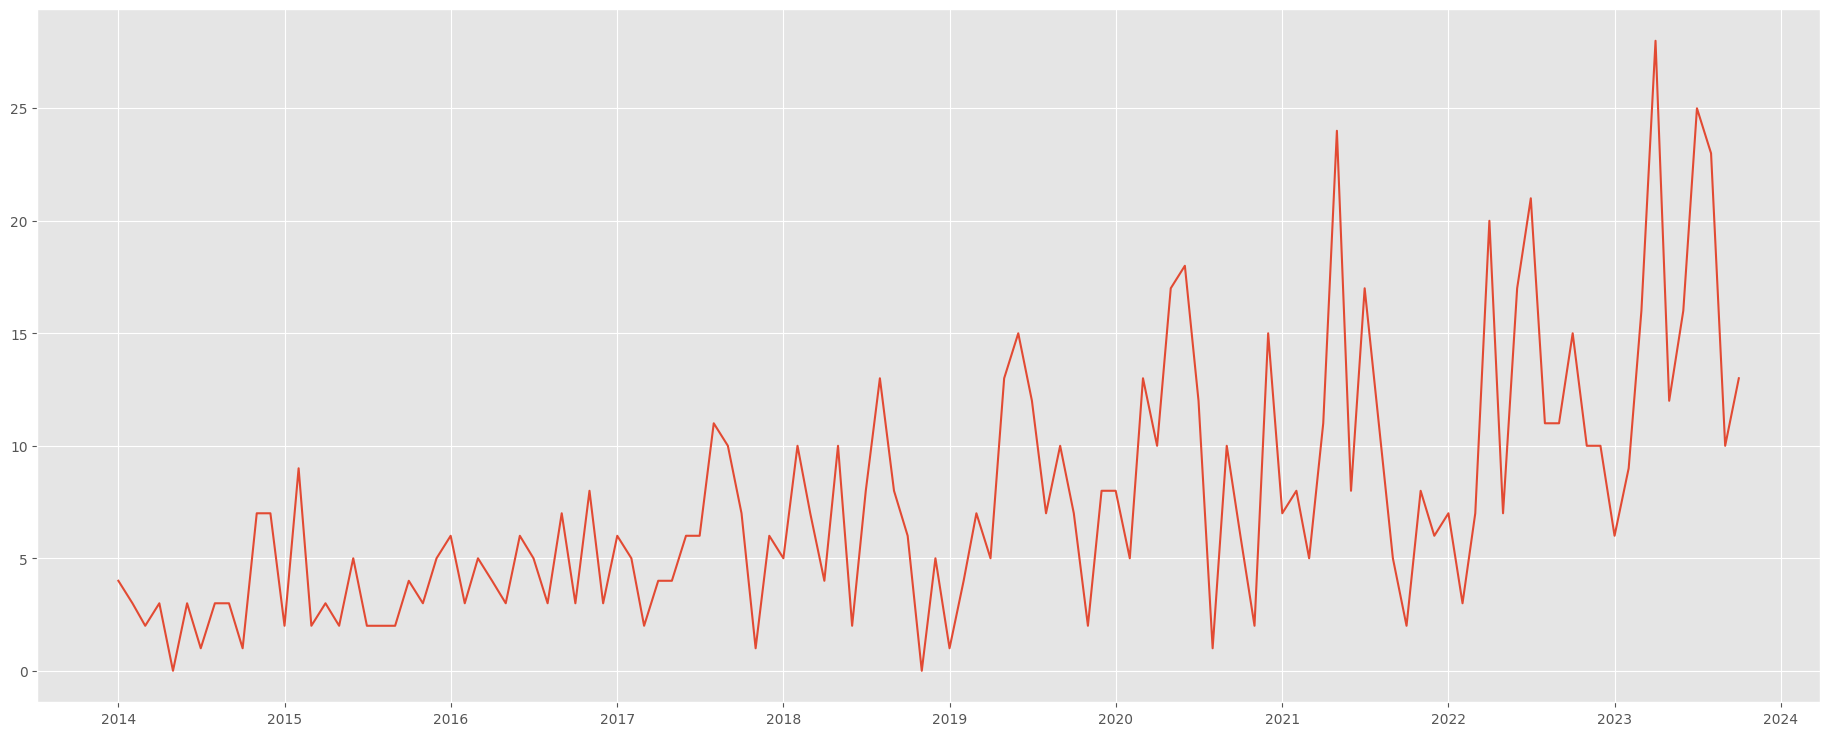

In [ ]:
plt.plot(data['y'])

проверим на стационарность

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(data['y'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: 0.968985249129989
p-value: 0.9939276849690207
Critical Values: {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}


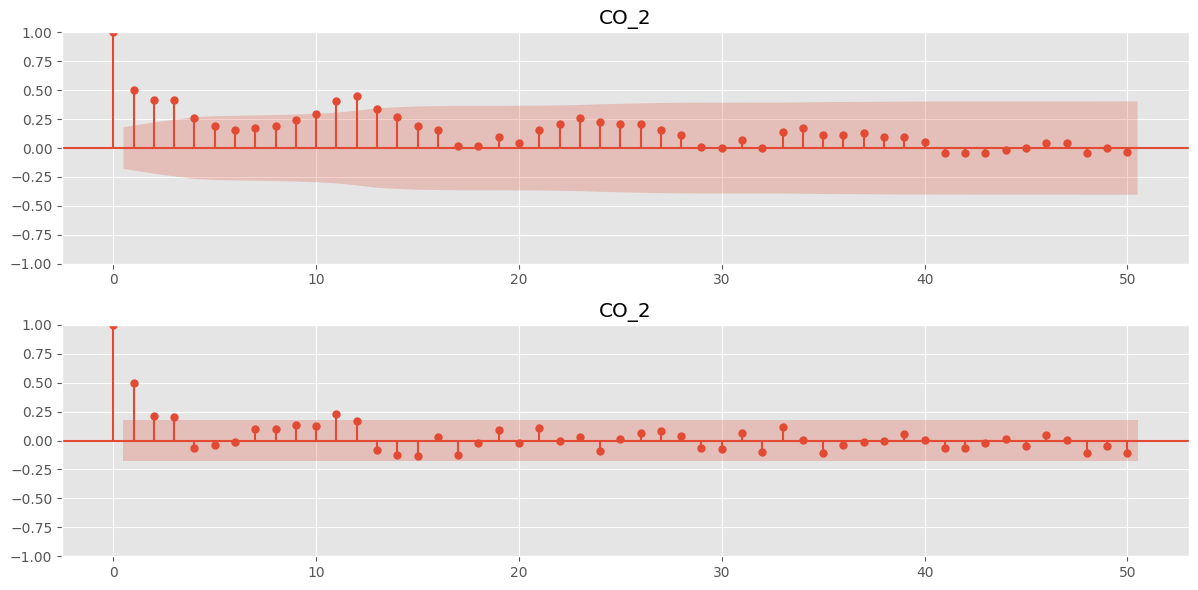

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(data['y'], lags=50, ax=plt.gca(), title='CO_2')
plt.subplot(2, 1, 2)
plot_pacf(data['y'], lags=50, ax=plt.gca(), title='CO_2')
plt.tight_layout()
plt.show()


# построим ARIMA, prophet и LSTM на примере

## SARIMA

In [ ]:
data

,y
date,
2014-01-01,4
2014-02-01,3
2014-03-01,2
2014-04-01,3
2014-05-01,0
...,...
2023-06-01,16
2023-07-01,25
2023-08-01,23


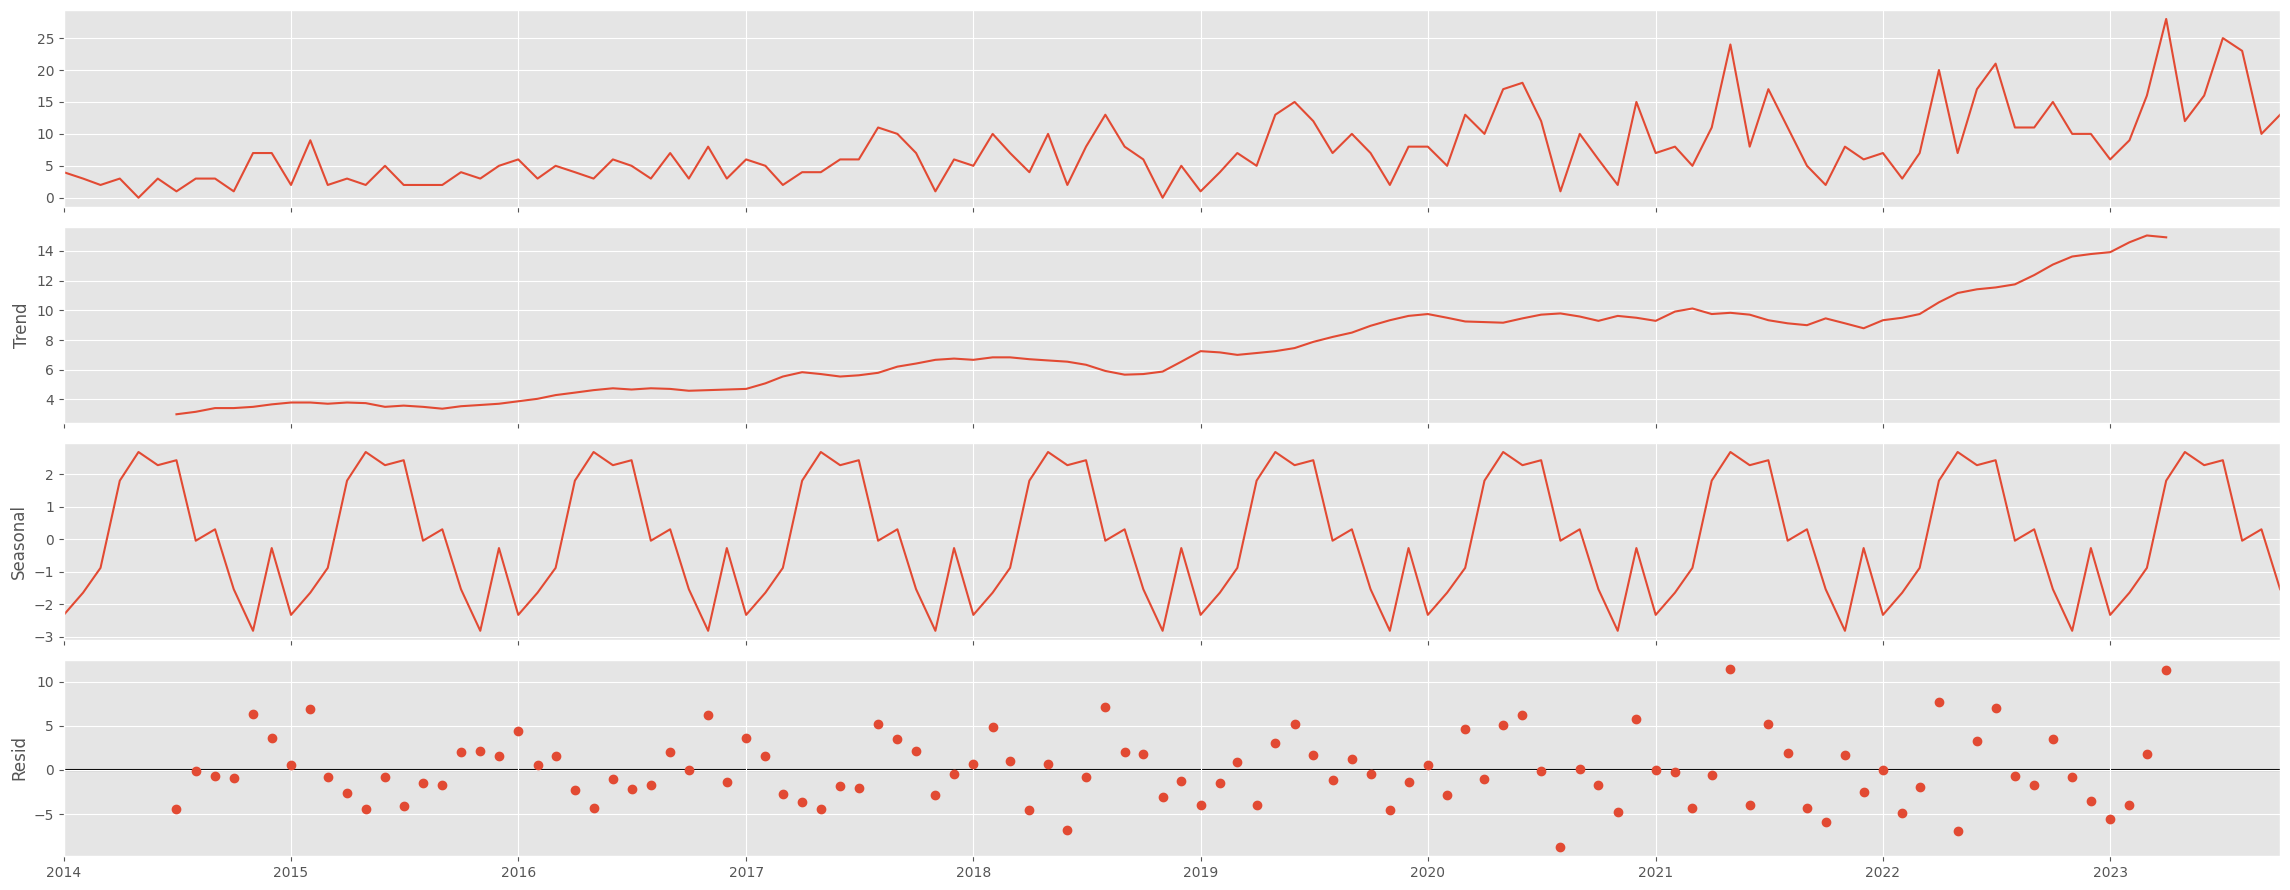

In [ ]:
fig = seasonal_decompose(data).plot()

In [ ]:
from pmdarima import auto_arima # автоматический подбор параметров
auto_arima(data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  118
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -343.522
Date:                Sat, 25 Nov 2023   AIC                            693.045
Time:                        20:14:43   BIC                            701.331
Sample:                    01-01-2014   HQIC                           696.409
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1936      0.118      1.643      0.100      -0.037       0.425
ma.L1         -0.8961      0.052    -17.321      0.000      -0.998      -0.795
sigma2        20.5599      2.185      9.408      0.000      16.276      24.843
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                18.55
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               8.70   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train = data[:-12]
test = data[-12:]

In [ ]:
st_model = SARIMAX(train, order=(1, 1, 1), seasonal_order= (1,0,0,12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
st_prediction = st_model.forecast(12)
st_prediction

2022-11-01    10.861953
2022-12-01    10.087122
2023-01-01    10.387395
2023-02-01     9.167894
2023-03-01    10.387265
2023-04-01    14.350233
2023-05-01    10.387265
2023-06-01    13.435702
2023-07-01    14.655077
2023-08-01    11.606640
2023-09-01    11.606640
2023-10-01    12.826015
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
test.join(st_prediction)

,y,predicted_mean
date,,
2022-11-01,10,10.861953
2022-12-01,10,10.087122
2023-01-01,6,10.387395
2023-02-01,9,9.167894
2023-03-01,16,10.387265
2023-04-01,28,14.350233
2023-05-01,12,10.387265
2023-06-01,16,13.435702
2023-07-01,25,14.655077


In [ ]:
mse = MSE(test, st_prediction)
print('MAPE:', MAPE(test, st_prediction))
print('RMSE:', mse**.5)
print('MSE:', mse)

MAPE: 0.25507945730531173
RMSE: 6.366979223297283
MSE: 40.53842442989927


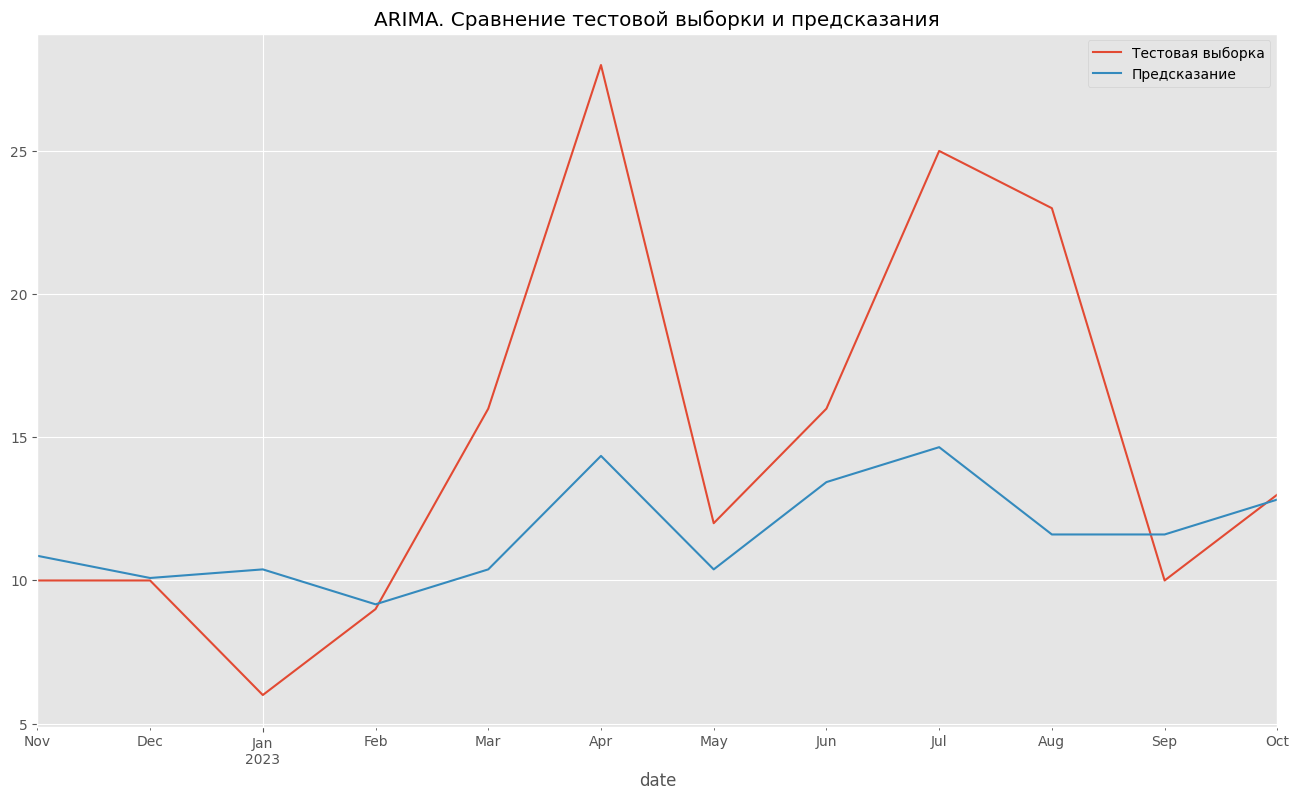

In [ ]:
test.plot(title='ARIMA. Сравнение тестовой выборки и предсказания')
st_prediction.plot(figsize=(16,9), legend=True).legend(['Тестовая выборка', 'Предсказание'])

In [ ]:
s_prediction_future = SARIMAX(data, order=(1, 1, 1), seasonal_order= (1,0,0,12)).fit().predict(start=len(data), end=len(data)+12)
s_prediction_future

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-11-01    13.844331
2023-12-01    13.896908
2024-01-01    12.233760
2024-02-01    13.481847
2024-03-01    16.394010
2024-04-01    21.386288
2024-05-01    14.729917
2024-06-01    16.394010
2024-07-01    20.138219
2024-08-01    19.306172
2024-09-01    13.897870
2024-10-01    15.145940
2024-11-01    15.497201
Freq: MS, Name: predicted_mean, dtype: float64

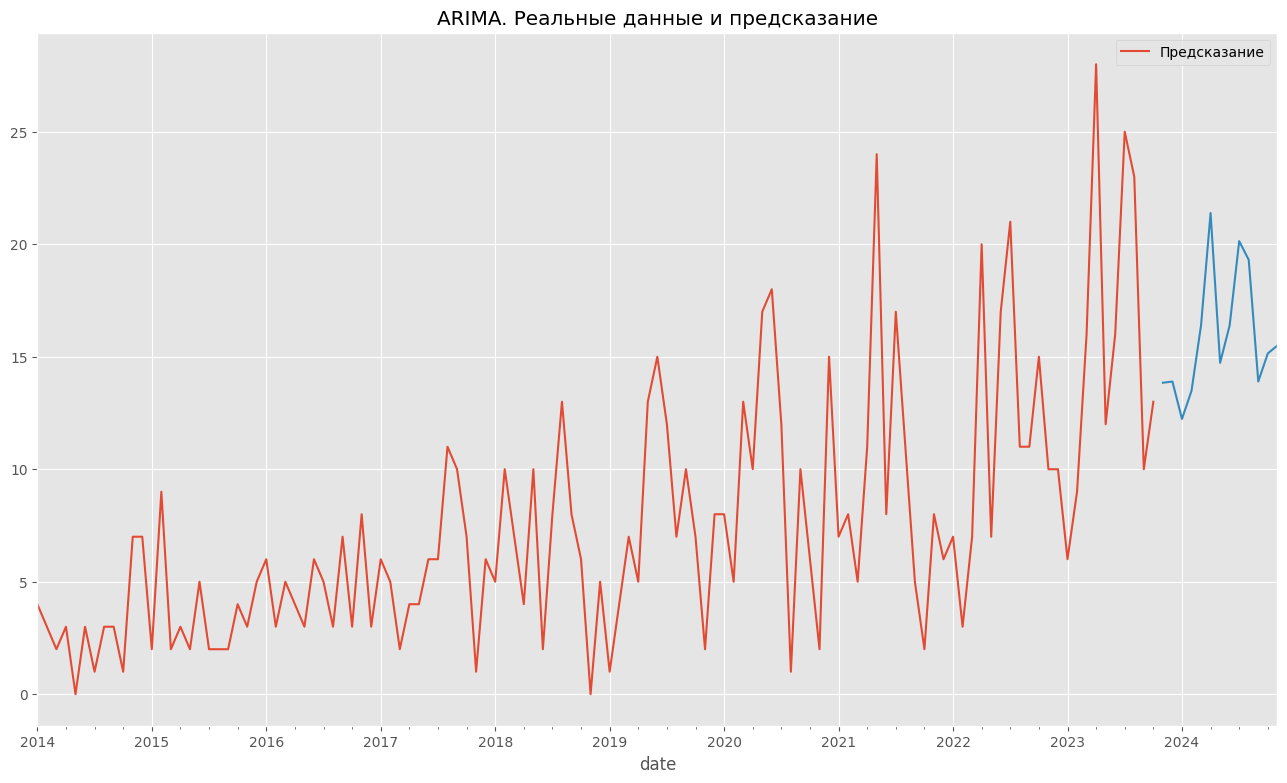

In [ ]:
ax1 = data.plot(title='ARIMA. Реальные данные и предсказание')
ax2 = s_prediction_future.plot(figsize=(16,9)).legend(['Предсказание'])

## Prophet

In [ ]:
df_prophet = data.reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2014-01-01,4
1,2014-02-01,3
2,2014-03-01,2
3,2014-04-01,3
4,2014-05-01,0


In [ ]:
train_prophet = df_prophet[:-12]
test_prophet = df_prophet[-12:]

In [ ]:
test_prophet

,ds,y
106,2022-11-01,10
107,2022-12-01,10
108,2023-01-01,6
109,2023-02-01,9
110,2023-03-01,16
111,2023-04-01,28
112,2023-05-01,12
113,2023-06-01,16
114,2023-07-01,25
115,2023-08-01,23


In [ ]:

model = Prophet(seasonality_mode='additive', )

model.fit(train_prophet)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0xz3ax38/ijllecva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0xz3ax38/00ujbe81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1960', 'data', 'file=/tmp/tmp0xz3ax38/ijllecva.json', 'init=/tmp/tmp0xz3ax38/00ujbe81.json', 'output', 'file=/tmp/tmp0xz3ax38/prophet_modelmszu8ty5/prophet_model-20231125201515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


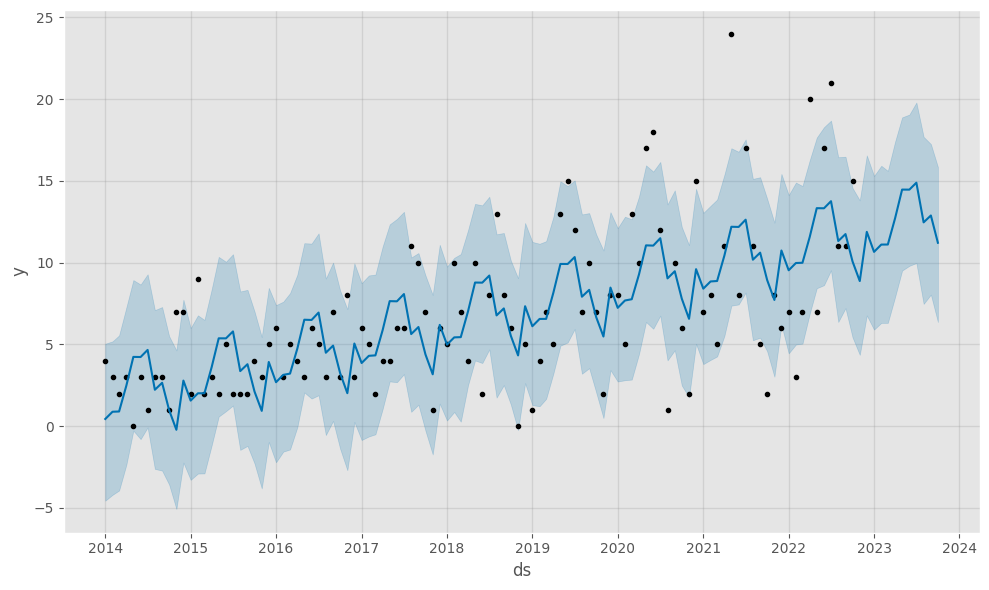

In [ ]:
ax = model.plot(forecast)

In [ ]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']][-12:])
p_prediction

,y,yhat
ds,,
2022-11-01,10,8.877747
2022-12-01,10,11.885896
2023-01-01,6,10.662660
2023-02-01,9,11.108383
2023-03-01,16,11.111892
2023-04-01,28,12.717516
2023-05-01,12,14.470693
2023-06-01,16,14.468203
2023-07-01,25,14.892216


In [ ]:
mse = MSE(p_prediction['y'], p_prediction['yhat'])
print('Prophet')
print('MAPE:', MAPE(p_prediction['y'], p_prediction['yhat']))
print('RMSE:', mse**.5)
print('MSE:', mse)

Prophet
MAPE: 0.3127551318760799
RMSE: 6.592394610768601
MSE: 43.459666704090886


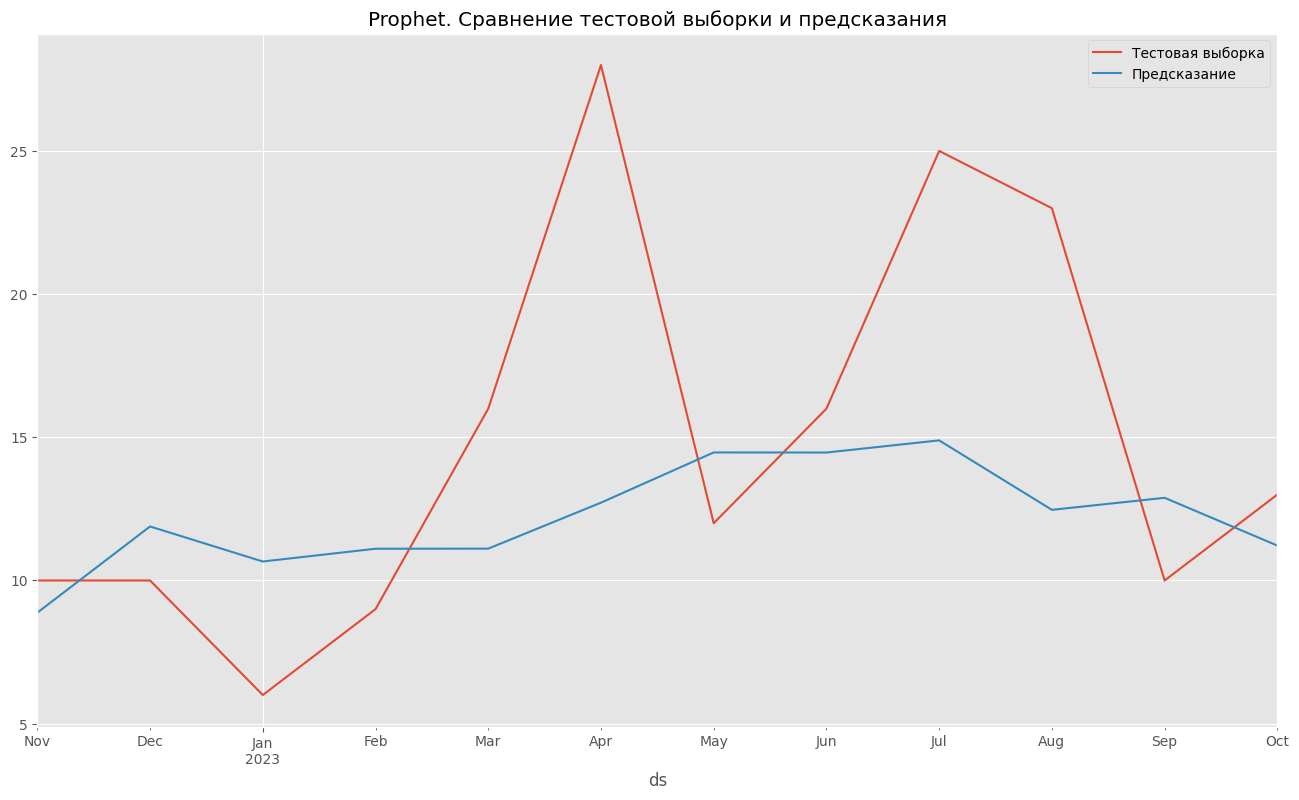

In [ ]:
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

In [ ]:
prediction = forecast.set_index('ds')[['yhat']]
prediction[-12:]

,yhat
ds,
2022-11-01,8.877747
2022-12-01,11.885896
2023-01-01,10.662660
2023-02-01,11.108383
2023-03-01,11.111892
2023-04-01,12.717516
2023-05-01,14.470693
2023-06-01,14.468203
2023-07-01,14.892216


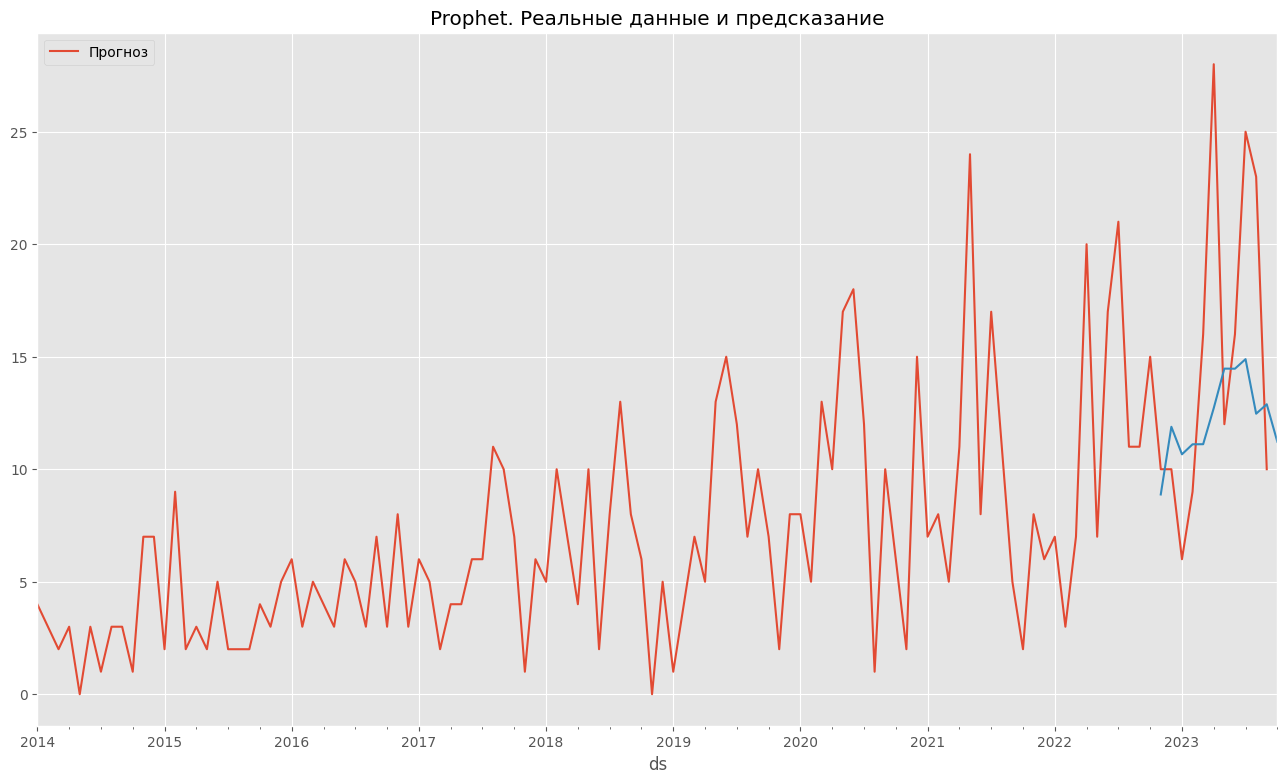

In [ ]:
ax1 = df_prophet[:-1].set_index('ds').plot(title='Prophet. Реальные данные и предсказание')
ax2 = prediction['yhat'][-12:].plot(figsize=(16,9)).legend(['Прогноз'])

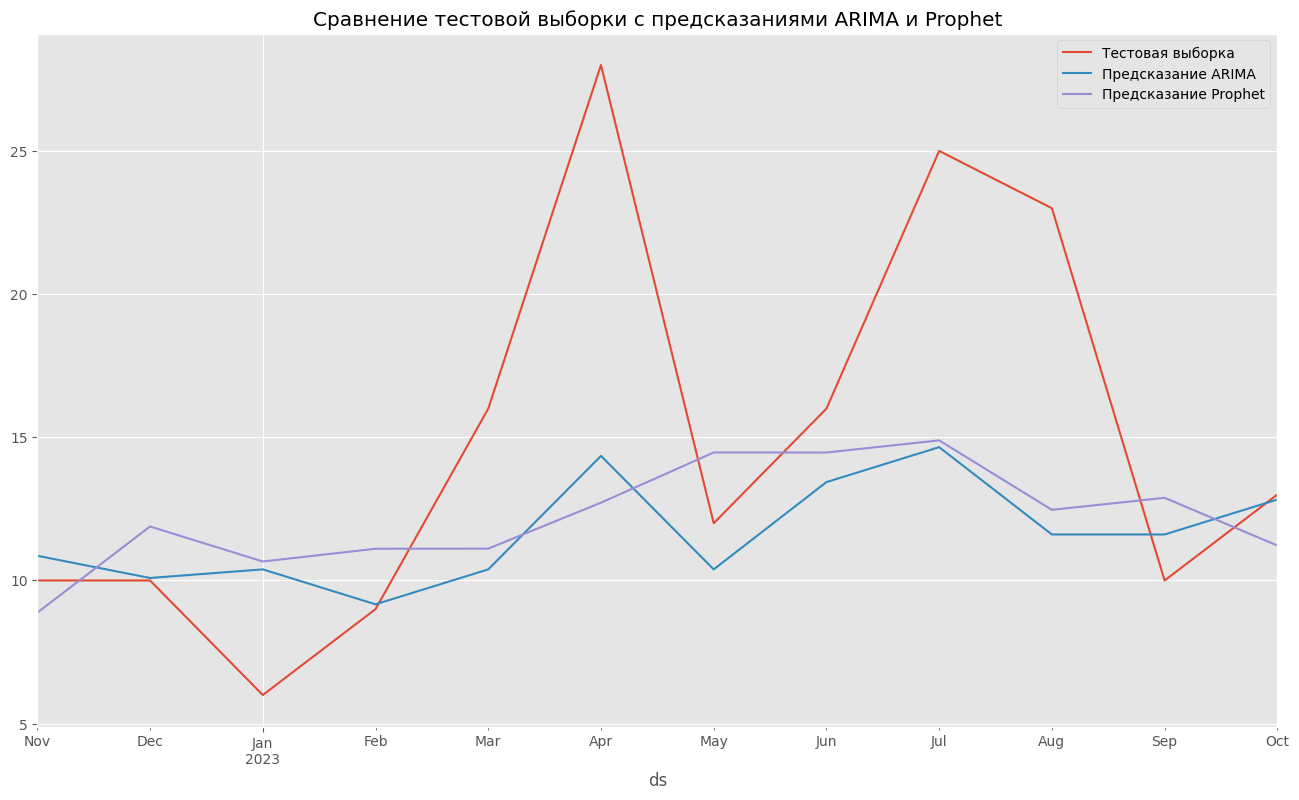

In [ ]:
ax1 = test.plot(title='Сравнение тестовой выборки с предсказаниями ARIMA и Prophet')
ax2 = st_prediction.plot(figsize=(16,9), legend=True)
ax3 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание ARIMA', 'Предсказание Prophet'])

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# предсказывать будем значение interpolated
dataset = df_prophet[['y']].to_numpy()
dataset = dataset.astype('float32')


In [ ]:
# разделить на трейн и тест
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

# train = data[:-12]
# test = data[-12:]

# нормализация
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# 496 значений размерностью 1 для обучения и 212 для тестирования
train.shape, test.shape

((82, 1), (36, 1))

In [ ]:
# нарезать данные на окна размера seq_length в формате:
# sequence: [1, 2, 3], targets: [4], sequence: [2, 3, 4], targets: [5]
def create_sequences(dataset, seq_length=1):
    sequence, targets = [], []
    for i in range(len(dataset) - seq_length):
        x_batch = dataset[i:(i+seq_length)]
        y_batch = dataset[i+seq_length]
        sequence.append(x_batch)
        targets.append(y_batch)
    return np.array(sequence), np.array(targets)


# создать данные для обучения и тестирования
seq_length = 1
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# X_train: 493 элемента, состоящих из seq_length значений цены размерности 1
# y_train: 493 следующих элмента для каждого элемнта из seq_length значений X_train
X_train.shape, y_train.shape

((81, 1, 1), (81, 1))

In [ ]:
X_test.shape, y_test.shape

((35, 1, 1), (35, 1))

In [ ]:
# преобразовать из numpy в torch

X_train, y_train, X_test, y_test = [torch.tensor(tensor, dtype=torch.float) for tensor in (X_train, y_train, X_test, y_test)]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([81, 1, 1]),
 torch.Size([81, 1]),
 torch.Size([35, 1, 1]),
 torch.Size([35, 1]))

Model

In [ ]:
# линейный слой принимает выход последнего скрытого состояния LSTM
class LstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(X_train.shape[-1], 50, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        out = self.linear(h)
        return out.squeeze(0)

# создание модели
model = LstmModel()
print(model)

# проверка работы модели
predict = model(X_train)
predict.shape

LstmModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


torch.Size([81, 1])

In [ ]:
%%time
torch.manual_seed(111)

# заново создать модель, функцию ошибки и оптимизатор
model = LstmModel()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

# обучение num_epochs эпох с размером батча batch_size
batch_size = 1
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    # ==================== TRAIN ====================
    for i in range(0, len(X_train), batch_size):
        x = X_train[i : i + batch_size]
        y = y_train[i : i + batch_size]

        predict = model(x)
        loss = loss_fn(predict, y)
        train_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

    # ================ VALIDATION =====================
    with torch.inference_mode():
        for i in range(0, len(X_test), batch_size):
            x = X_test[i : i + batch_size]
            y = y_test[i : i + batch_size]

            predict = model(x)
            loss = loss_fn(predict, y)
            val_loss += loss.item()

    print(f'Epoch [{epoch+  1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/5], Train Loss: 4.8388, Val Loss: 7.2268
Epoch [2/5], Train Loss: 3.6265, Val Loss: 6.5218
Epoch [3/5], Train Loss: 3.6797, Val Loss: 6.4097
Epoch [4/5], Train Loss: 3.6071, Val Loss: 6.2787
Epoch [5/5], Train Loss: 3.5478, Val Loss: 6.1503
CPU times: user 3 s, sys: 173 ms, total: 3.17 s
Wall time: 4.56 s


In [ ]:
model.eval()
with torch.inference_mode():
    x_pred_train = model(X_train)
    x_pred_test = model(X_test)

x_pred_train.shape, x_pred_test.shape

(torch.Size([81, 1]), torch.Size([35, 1]))

In [ ]:
# значения для тренировочных данных, предсказанные моделью
x_pred_train = scaler.inverse_transform(x_pred_train)
# реальные значения из датасета
y_real_train = scaler.inverse_transform(y_train)

# тоже самое для теста
x_pred_test = scaler.inverse_transform(x_pred_test)
y_real_test = scaler.inverse_transform(y_test)

x_pred_train.shape, y_real_train.shape

((81, 1), (81, 1))

In [ ]:
r2_score_train = r2_score(y_real_train, x_pred_train)
print(f'R2 Score train: {r2_score_train:.2f}')

r2_score_test = r2_score(y_real_test, x_pred_test)
print(f'R2 Score test: {r2_score_test:.2f}')

R2 Score train: 0.09
R2 Score test: -0.37


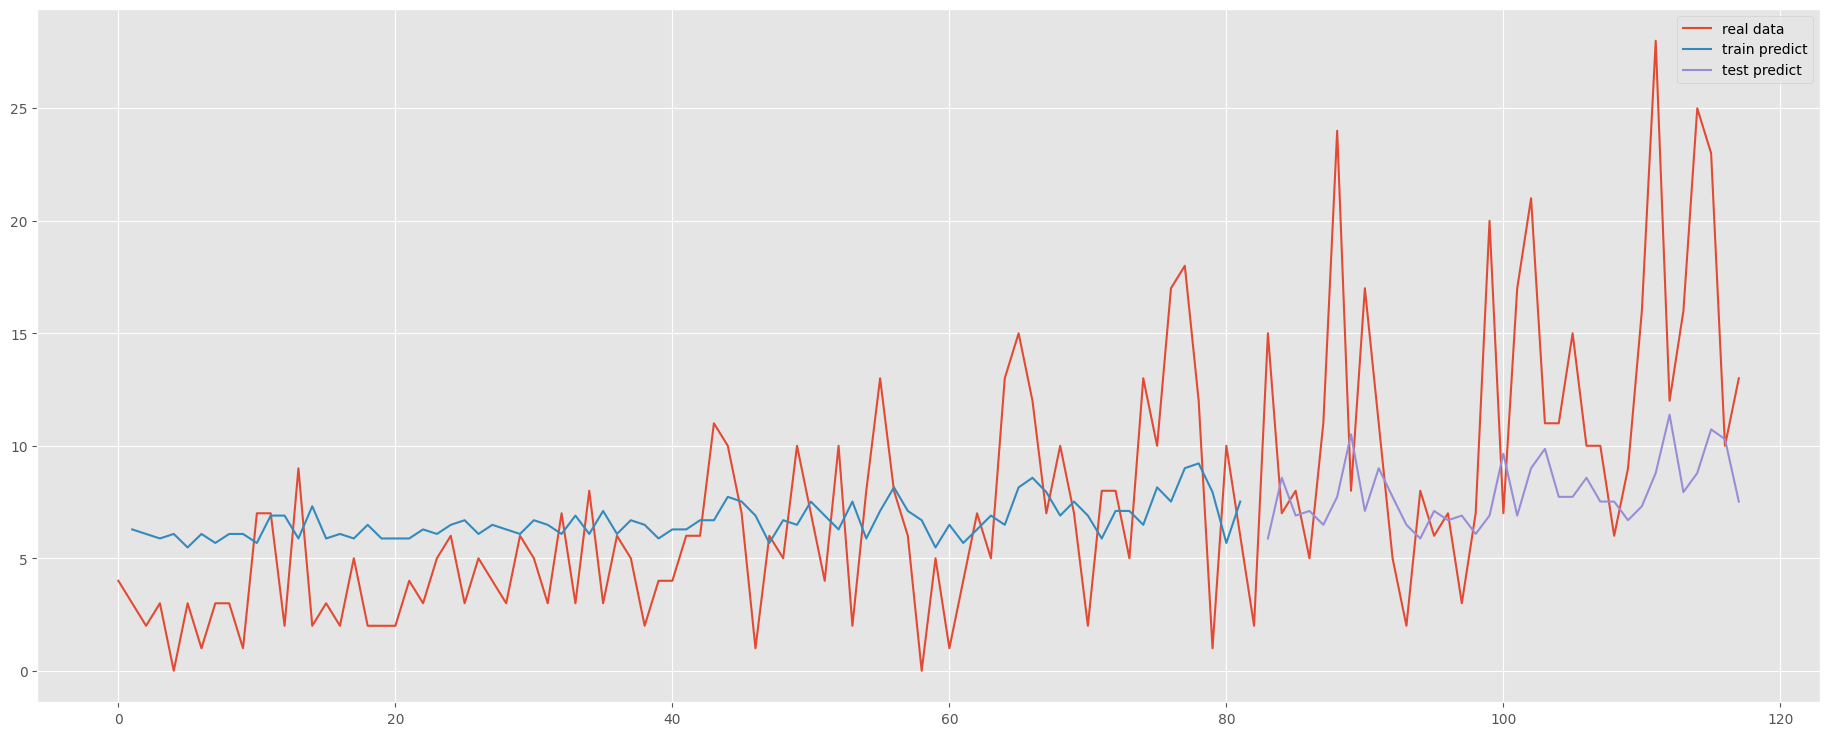

In [ ]:
# x_line - заготовка для оси икс для отрисовки
x_line = np.arange(len(dataset))

# отрисовка исходных значений датасета
plt.plot(x_line, dataset, label='real data')

# отрисовка предсказанных моделью значений для тренировки
plt.plot(x_line[seq_length : len(x_pred_train) + seq_length], x_pred_train, label='train predict')

# отрисовка предсказанных моделью значений для тестирования
plt.plot(x_line[len(x_pred_train) + (seq_length*2):], x_pred_test, label='test predict')
plt.legend()
plt.show()

In [ ]:
lstm_pred = x_pred_test[-12:]
lstm_pred

array([[ 8.57643568],
       [ 7.52028156],
       [ 7.52028156],
       [ 6.69130732],
       [ 7.31154776],
       [ 8.78978609],
       [11.38029519],
       [ 7.94040829],
       [ 8.78978609],
       [10.72973827],
       [10.29653041],
       [ 7.52028156]])

In [ ]:
df_res = pd.DataFrame(lstm_pred, columns=['lstm_pred'])
df_res['st_prediction'] = st_prediction.to_numpy()
df_res['prophet_prediction'] = p_prediction['yhat'].to_numpy()
df_res['fact'] = p_prediction['y'].to_numpy()
df_res

,lstm_pred,st_prediction,prophet_prediction,fact
0,8.576436,10.861953,8.877747,10
1,7.520282,10.087122,11.885896,10
2,7.520282,10.387395,10.662660,6
3,6.691307,9.167894,11.108383,9
4,7.311548,10.387265,11.111892,16
5,8.789786,14.350233,12.717516,28
6,11.380295,10.387265,14.470693,12
7,7.940408,13.435702,14.468203,16
8,8.789786,14.655077,14.892216,25
9,10.729738,11.606640,12.467031,23


<Axes: >

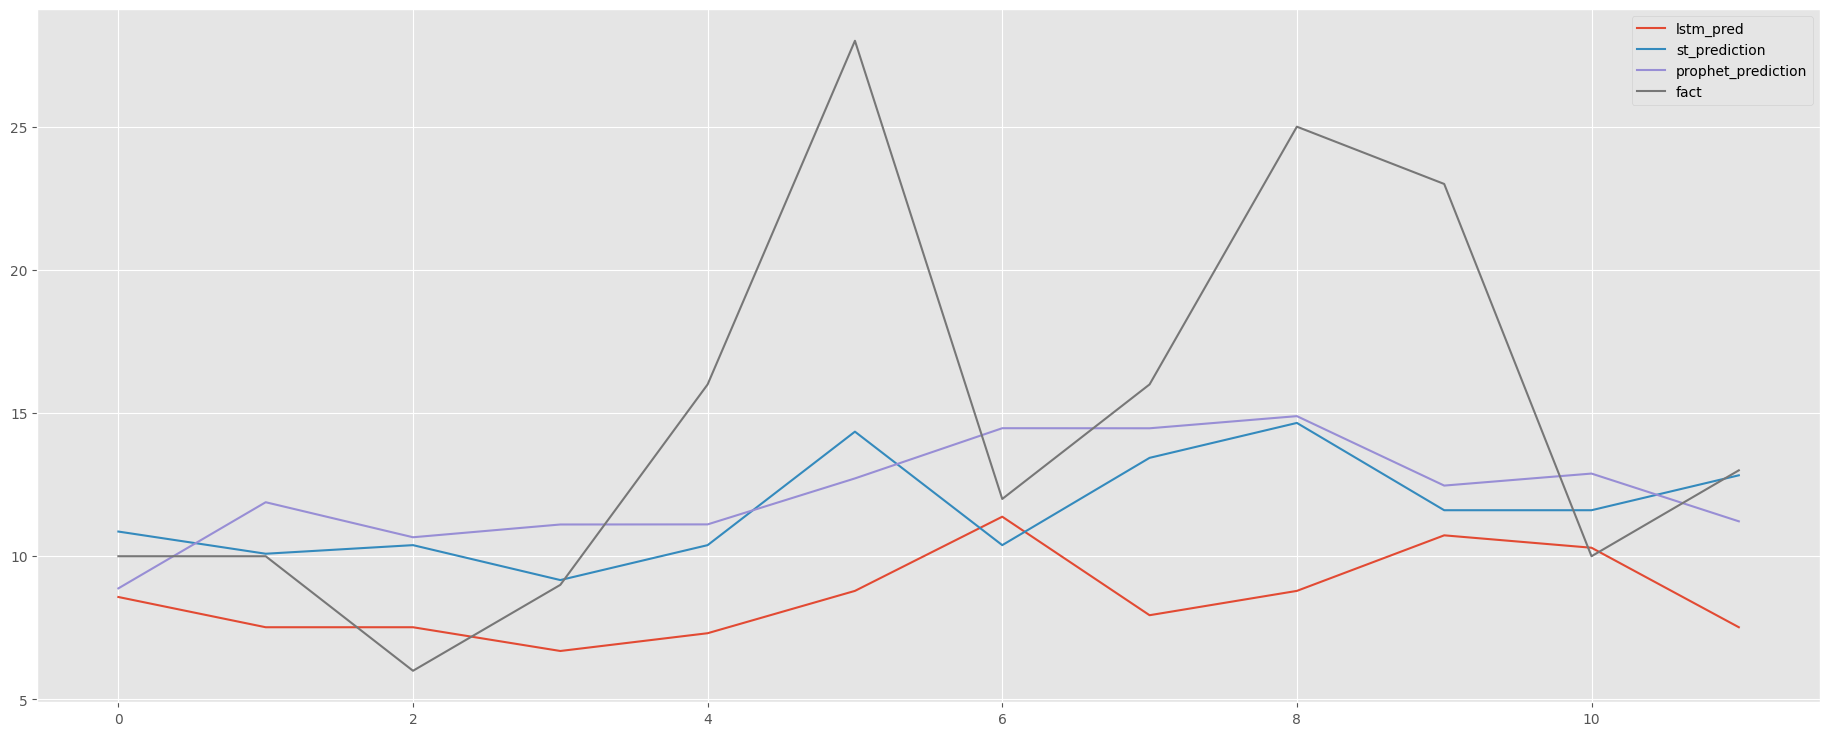

In [ ]:
df_res.plot()


## GRU

In [ ]:
# линейный слой принимает выход последнего скрытого состояния LSTM
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(X_train.shape[-1], 50, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        out, h = self.gru(x)
        out = self.linear(h)
        return out.squeeze(0)

# создание модели
model_gru = GRUModel()
print(model_gru)

# проверка работы модели
predict_gru = model_gru(X_train)
predict_gru.shape

GRUModel(
  (gru): GRU(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


torch.Size([81, 1])

In [ ]:
%%time
torch.manual_seed(111)

# заново создать модель, функцию ошибки и оптимизатор
model_gru = GRUModel()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model_gru.parameters())

# обучение num_epochs эпох с размером батча batch_size
batch_size = 1
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    # ==================== TRAIN ====================
    for i in range(0, len(X_train), batch_size):
        x = X_train[i : i + batch_size]
        y = y_train[i : i + batch_size]

        predict = model_gru(x)
        loss = loss_fn(predict, y)
        train_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

    # ================ VALIDATION =====================
    with torch.inference_mode():
        for i in range(0, len(X_test), batch_size):
            x = X_test[i : i + batch_size]
            y = y_test[i : i + batch_size]

            predict = model_gru(x)
            loss = loss_fn(predict, y)
            val_loss += loss.item()

    print(f'Epoch [{epoch+  1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/5], Train Loss: 5.3837, Val Loss: 5.8430
Epoch [2/5], Train Loss: 3.6036, Val Loss: 5.7081
Epoch [3/5], Train Loss: 3.5076, Val Loss: 5.6200
Epoch [4/5], Train Loss: 3.4415, Val Loss: 5.5398
Epoch [5/5], Train Loss: 3.3902, Val Loss: 5.4742
CPU times: user 943 ms, sys: 8.03 ms, total: 951 ms
Wall time: 1 s


In [ ]:
model_gru.eval()
with torch.inference_mode():
    x_pred_train_gru = model(X_train)
    x_pred_test_gru = model(X_test)

x_pred_train_gru.shape, x_pred_test_gru.shape

(torch.Size([81, 1]), torch.Size([35, 1]))

In [ ]:
# значения для тренировочных данных, предсказанные моделью
x_pred_train_gru = scaler.inverse_transform(x_pred_train_gru)
# реальные значения из датасета
y_real_train = scaler.inverse_transform(y_train)

# тоже самое для теста
x_pred_test_gru = scaler.inverse_transform(x_pred_test_gru)
y_real_test = scaler.inverse_transform(y_test)

x_pred_train_gru.shape, y_real_train.shape

((81, 1), (81, 1))

In [ ]:
r2_score_train = r2_score(y_real_train, x_pred_train_gru)
print(f'R2 Score train: {r2_score_train:.2f}')

r2_score_test = r2_score(y_real_test, x_pred_test_gru)
print(f'R2 Score test: {r2_score_test:.2f}')

R2 Score train: 0.09
R2 Score test: -0.37


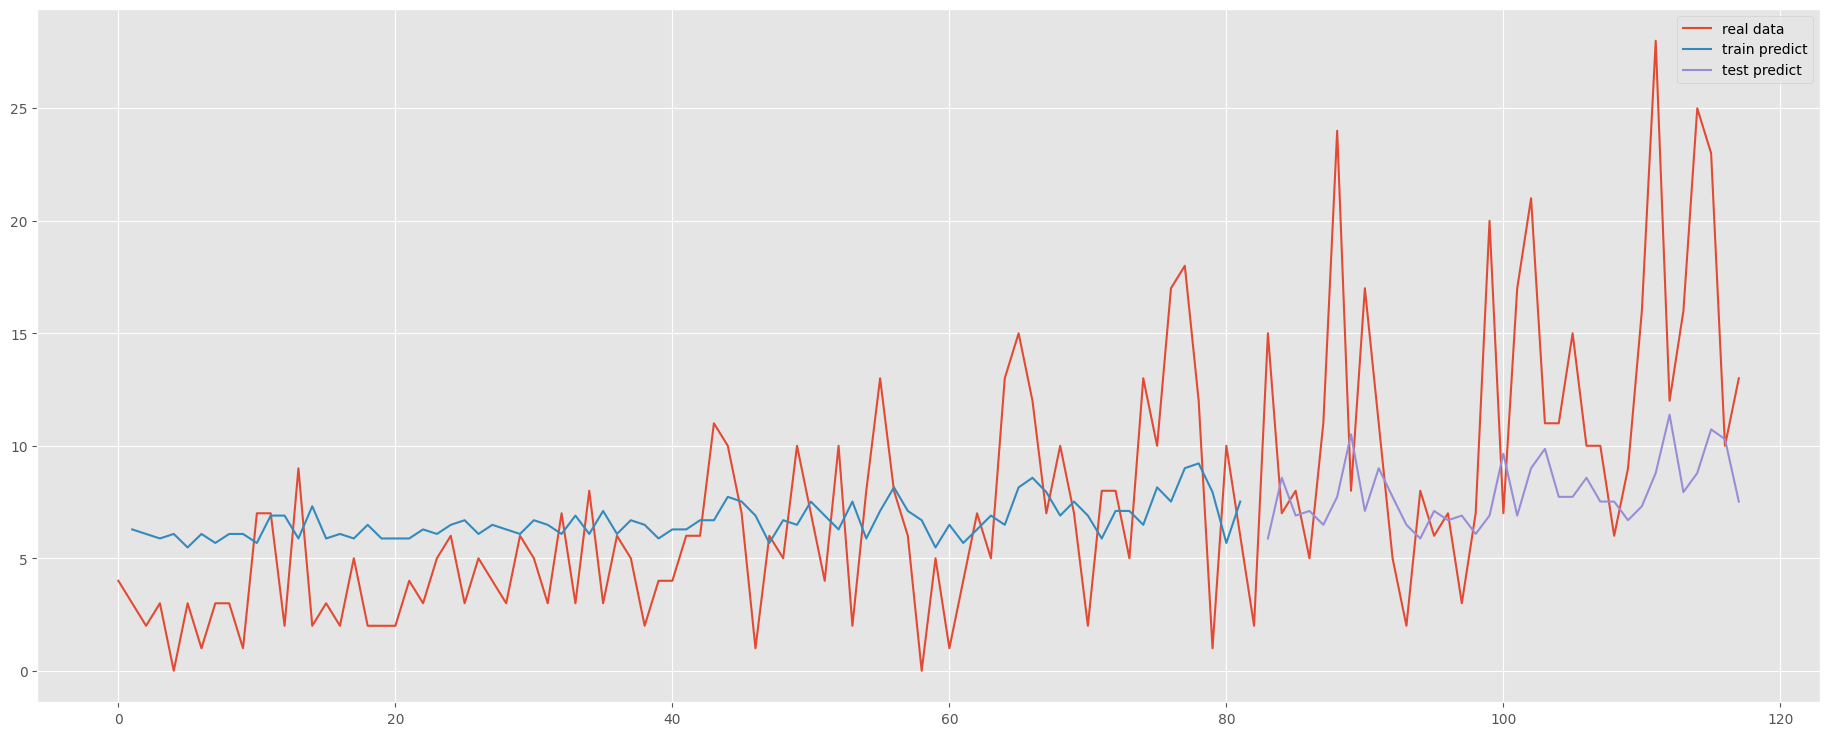

In [ ]:
# x_line - заготовка для оси икс для отрисовки
x_line = np.arange(len(dataset))

# отрисовка исходных значений датасета
plt.plot(x_line, dataset, label='real data')

# отрисовка предсказанных моделью значений для тренировки
plt.plot(x_line[seq_length : len(x_pred_train_gru) + seq_length], x_pred_train_gru, label='train predict')

# отрисовка предсказанных моделью значений для тестирования
plt.plot(x_line[len(x_pred_train_gru) + (seq_length*2):], x_pred_test_gru, label='test predict')
plt.legend()
plt.show()

In [ ]:
gru_pred = x_pred_test_gru[-12:]
gru_pred

array([[ 8.57643568],
       [ 7.52028156],
       [ 7.52028156],
       [ 6.69130732],
       [ 7.31154776],
       [ 8.78978609],
       [11.38029519],
       [ 7.94040829],
       [ 8.78978609],
       [10.72973827],
       [10.29653041],
       [ 7.52028156]])

In [ ]:

df_res['gru_pred'] = gru_pred

df_res

,lstm_pred,st_prediction,prophet_prediction,fact,gru_pred
0,8.576436,10.861953,8.877747,10,8.576436
1,7.520282,10.087122,11.885896,10,7.520282
2,7.520282,10.387395,10.662660,6,7.520282
3,6.691307,9.167894,11.108383,9,6.691307
4,7.311548,10.387265,11.111892,16,7.311548
5,8.789786,14.350233,12.717516,28,8.789786
6,11.380295,10.387265,14.470693,12,11.380295
7,7.940408,13.435702,14.468203,16,7.940408
8,8.789786,14.655077,14.892216,25,8.789786
9,10.729738,11.606640,12.467031,23,10.729738


<Axes: >

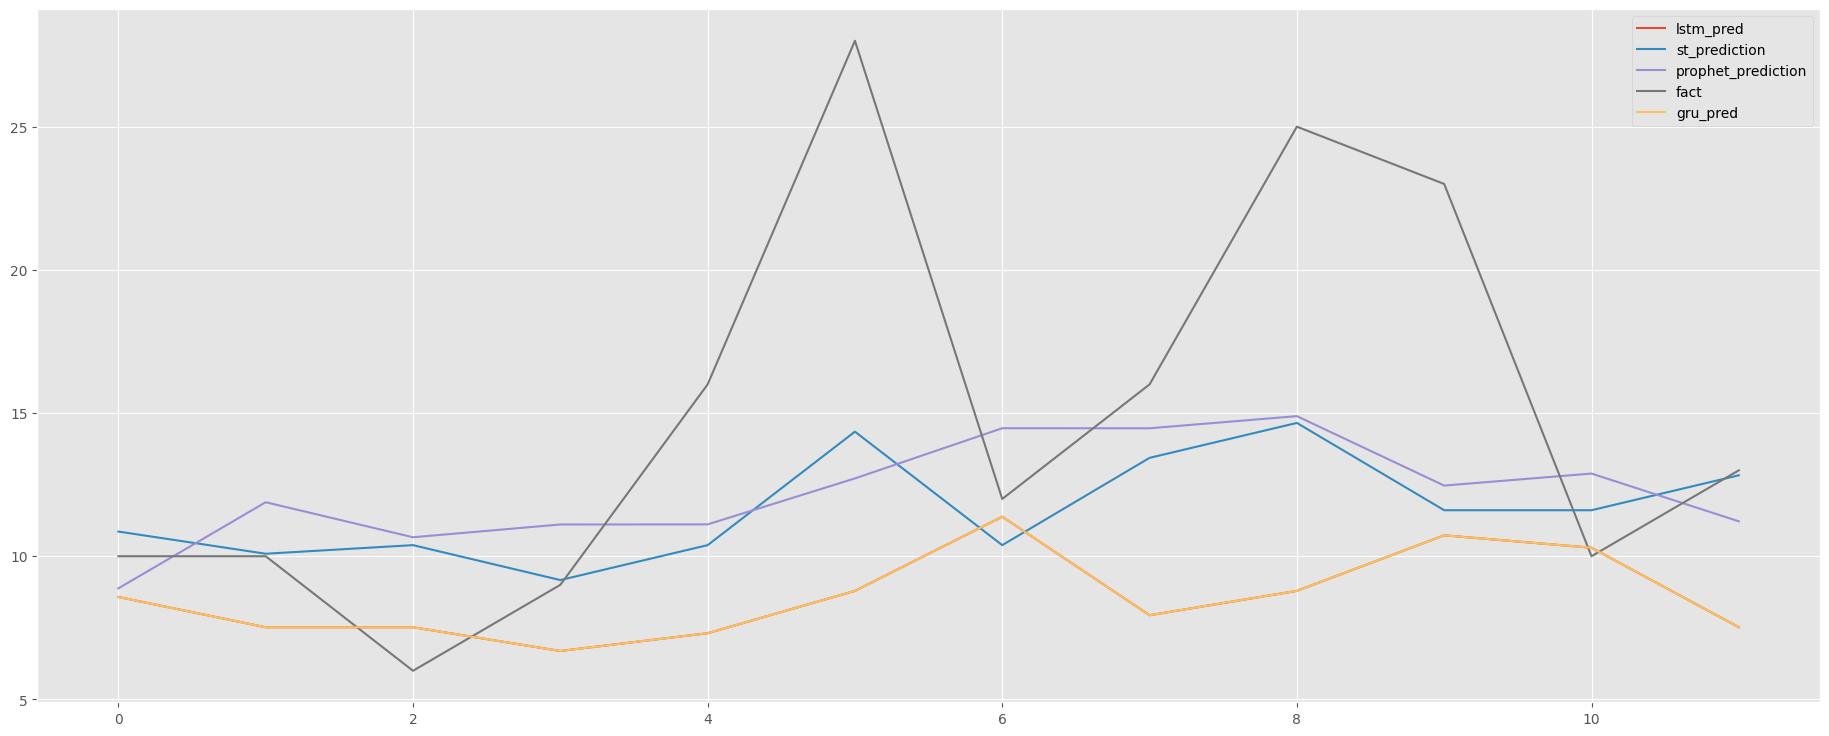

In [ ]:
df_res.plot()


## Tsfresh

In [ ]:
df_prophet1 = df_prophet.copy()


In [ ]:
df_prophet1

,ds,y
0,2014-01-01,4
1,2014-02-01,3
2,2014-03-01,2
3,2014-04-01,3
4,2014-05-01,0
...,...,...
113,2023-06-01,16
114,2023-07-01,25
115,2023-08-01,23
116,2023-09-01,10


In [ ]:
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False)

# fourier_order
model.add_seasonality(
      name = 'monthly',
     fourier_order = 6,
     period = 30
 )
# model.add_seasonality(period=30.4, components=5, name='monthly')

model.fit(df_prophet1)
# future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(df_prophet1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0xz3ax38/9q60vre5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0xz3ax38/e97_fj76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70089', 'data', 'file=/tmp/tmp0xz3ax38/9q60vre5.json', 'init=/tmp/tmp0xz3ax38/e97_fj76.json', 'output', 'file=/tmp/tmp0xz3ax38/prophet_modelqziik_bl/prophet_model-20231125201717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast['year'] = forecast['ds'].dt.year
forecast['month'] = forecast['ds'].dt.month
#forecast['day'] = forecast['ds'].dt.day

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,year,month
0,2014-01-01,1.439567,-3.634684,4.781809,1.439567,1.439567,-0.057835,-0.057835,-0.057835,-0.462047,...,-0.462047,-0.404212,-0.404212,-0.404212,0.0,0.0,0.0,0.774419,2014,1
1,2014-02-01,1.542526,-3.202036,5.350715,1.542526,1.542526,0.062262,0.062262,0.062262,-0.444524,...,-0.444524,-0.506786,-0.506786,-0.506786,0.0,0.0,0.0,0.856836,2014,2
2,2014-03-01,1.635522,-2.149332,6.154101,1.635522,1.635522,-0.010610,-0.010610,-0.010610,0.067826,...,0.067826,0.078436,0.078436,0.078436,0.0,0.0,0.0,1.746452,2014,3
3,2014-04-01,1.738481,-1.864376,6.414755,1.738481,1.738481,-0.057835,-0.057835,-0.057835,0.309202,...,0.309202,0.367037,0.367037,0.367037,0.0,0.0,0.0,2.276024,2014,4
4,2014-05-01,1.838119,-1.851882,6.707303,1.838119,1.838119,-0.057835,-0.057835,-0.057835,0.198835,...,0.198835,0.256669,0.256669,0.256669,0.0,0.0,0.0,2.203601,2014,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2023-06-01,12.858100,14.831811,23.721310,12.858100,12.858100,0.376151,0.376151,0.376151,0.493017,...,0.493017,0.116866,0.116866,0.116866,0.0,0.0,0.0,19.197361,2023,6
114,2023-07-01,12.957738,18.475531,26.986004,12.957738,12.957738,0.376151,0.376151,0.376151,0.764186,...,0.764186,0.388035,0.388035,0.388035,0.0,0.0,0.0,22.859863,2023,7
115,2023-08-01,13.060698,12.618680,21.048049,13.060698,13.060698,0.254450,0.254450,0.254450,0.305193,...,0.305193,0.050743,0.050743,0.050743,0.0,0.0,0.0,17.046734,2023,8
116,2023-09-01,13.163657,9.317155,17.734982,13.163657,13.163657,0.020205,0.020205,0.020205,0.042622,...,0.042622,0.022417,0.022417,0.022417,0.0,0.0,0.0,13.724725,2023,9


In [ ]:
coef_monthly = forecast.groupby('month', as_index=False).agg({'yearly':'mean'})
coef_monthly['yearly'] = coef_monthly['yearly'] +1
coef_monthly

,month,yearly
0,1,0.593462
1,2,0.493489
2,3,1.077884
3,4,1.367182
4,5,1.258003
5,6,1.118130
6,7,1.385847
7,8,1.048707
8,9,1.020321
9,10,0.921015


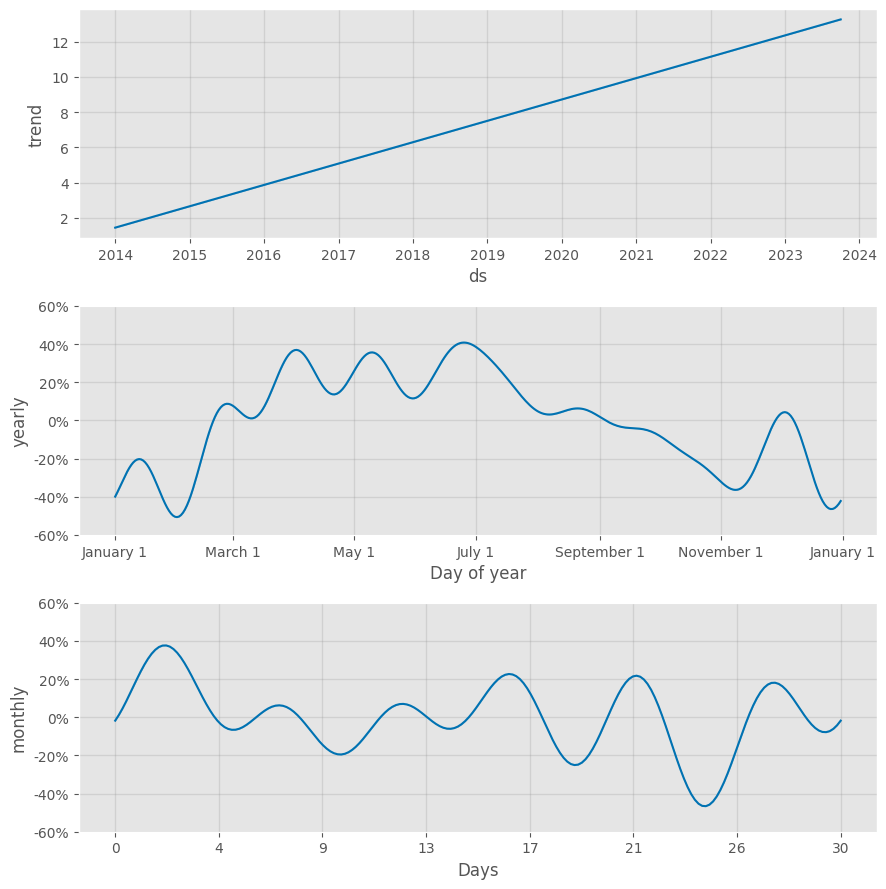

In [ ]:
fig = model.plot_components(forecast)

##CatBoost

In [ ]:
df = data.reset_index().copy()
df.columns = ['date', 'y']
df.head()

,date,y
0,2014-01-01,4
1,2014-02-01,3
2,2014-03-01,2
3,2014-04-01,3
4,2014-05-01,0


In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,y,year,month
0,2014-01-01,4,2014,1
1,2014-02-01,3,2014,2
2,2014-03-01,2,2014,3
3,2014-04-01,3,2014,4
4,2014-05-01,0,2014,5


In [ ]:
df_2 = df[['date', 'y']]
df_2.set_index('date', inplace=True)

In [ ]:
df_agg_m = df_2.resample('Y').mean()
df_agg_m

,y
date,
2014-12-31,3.083333
2015-12-31,3.416667
2016-12-31,4.666667
2017-12-31,5.666667
2018-12-31,6.500000
2019-12-31,7.583333
2020-12-31,9.750000
2021-12-31,9.333333
2022-12-31,11.583333


In [ ]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
df_rolled, y = make_forecasting_frame(df_agg_m['y'], kind='date', max_timeshift=None, rolling_direction=1)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling:  80%|████████  | 8/10 [00:00<00:00, 78.08it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 10/10 [00:00<00:00, 73.45it/s]


In [ ]:
df_rolled.head(5)

,id,time,value,kind
1,"(id, 2015-12-31 00:00:00)",2014-12-31,3.083333,date
3,"(id, 2016-12-31 00:00:00)",2014-12-31,3.083333,date
4,"(id, 2016-12-31 00:00:00)",2015-12-31,3.416667,date
6,"(id, 2017-12-31 00:00:00)",2014-12-31,3.083333,date
7,"(id, 2017-12-31 00:00:00)",2015-12-31,3.416667,date


In [ ]:
y.head()

(id, 2015-12-31 00:00:00)    3.416667
(id, 2016-12-31 00:00:00)    4.666667
(id, 2017-12-31 00:00:00)    5.666667
(id, 2018-12-31 00:00:00)    6.500000
(id, 2019-12-31 00:00:00)    7.583333
Name: value, dtype: float64

In [ ]:
from tsfresh import extract_features
df_features = extract_features(df_rolled.drop(columns='kind'), column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


In [ ]:
df_features.head()

value__variance_larger_than_standard_deviation  \
id 2015-12-31                                             0.0   
   2016-12-31                                             0.0   
   2017-12-31                                             0.0   
   2018-12-31                                             1.0   
   2019-12-31                                             1.0   

               value__has_duplicate_max  value__has_duplicate_min  \
id 2015-12-31                       0.0                       0.0   
   2016-12-31                       0.0                       0.0   
   2017-12-31                       0.0                       0.0   
   2018-12-31                       0.0                       0.0   
   2019-12-31                       0.0                       0.0   

               value__has_duplicate  value__sum_values  value__abs_energy  \
id 2015-12-31                   0.0           3.083333           9.506944   
   2016-12-31                   0.0           6.500000          21.180556   
   2017-12-31                   0.0          11.166667          42.958333   
   2018-12-31                   0.0          16.833333          75.069444   
   2019-12-31                   0.0          23.333333         117.319444   

               value__mean_abs_change  value__mean_change  \
id 2015-12-31                     NaN                 NaN   
   2016-12-31                0.333333            0.333333   
   2017-12-31                0.791667            0.791667   
   2018-12-31                0.861111            0.861111   
   2019-12-31                0.854167            0.854167   

               value__mean_second_derivative_central  value__median  ...  \
id 2015-12-31                                    NaN       3.083333  ...   
   2016-12-31                                    NaN       3.250000  ...   
   2017-12-31                               0.458333       3.416667  ...   
   2018-12-31                               0.166667       4.041667  ...   
   2019-12-31                               0.083333       4.666667  ...   

               value__fourier_entropy__bins_5  \
id 2015-12-31                             NaN   
   2016-12-31                       -0.000000   
   2017-12-31                        0.693147   
   2018-12-31                        1.098612   
   2019-12-31                        0.636514   

               value__fourier_entropy__bins_10  \
id 2015-12-31                              NaN   
   2016-12-31                        -0.000000   
   2017-12-31                         0.693147   
   2018-12-31                         1.098612   
   2019-12-31                         1.098612   

               value__fourier_entropy__bins_100  \
id 2015-12-31                               NaN   
   2016-12-31                         -0.000000   
   2017-12-31                          0.693147   
   2018-12-31                          1.098612   
   2019-12-31                          1.098612   

               value__permutation_entropy__dimension_3__tau_1  \
id 2015-12-31                                             NaN   
   2016-12-31                                             NaN   
   2017-12-31                                            -0.0   
   2018-12-31                                            -0.0   
   2019-12-31                                            -0.0   

               value__permutation_entropy__dimension_4__tau_1  \
id 2015-12-31                                             NaN   
   2016-12-31                                             NaN   
   2017-12-31                                             NaN   
   2018-12-31                                            -0.0   
   2019-12-31                                            -0.0   

               value__permutation_entropy__dimension_5__tau_1  \
id 2015-12-31                                             NaN   
   2016-12-31                                             NaN   
   2017-12-31                             

In [ ]:
df_features = df_features.sort_index()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features,
                                                    y,
                                                    train_size=0.9,
                                                    shuffle=False,
                                                    random_state = 42)

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.8 MB/s eta 0:00:00


In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

In [ ]:
%%time
from catboost import CatBoostRegressor

catboost_model_basic_regr = CatBoostRegressor(n_estimators=200,
                                              loss_function='RMSE',
                                              eval_metric='MSLE',
                                              logging_level='Silent')

_ = catboost_model_basic_regr.fit(train_dataset,
                                  eval_set = test_dataset,
                                  use_best_model = True,
                                  plot = False,
                                  verbose=False
                                  )

CPU times: user 1.5 s, sys: 137 ms, total: 1.63 s
Wall time: 3.71 s


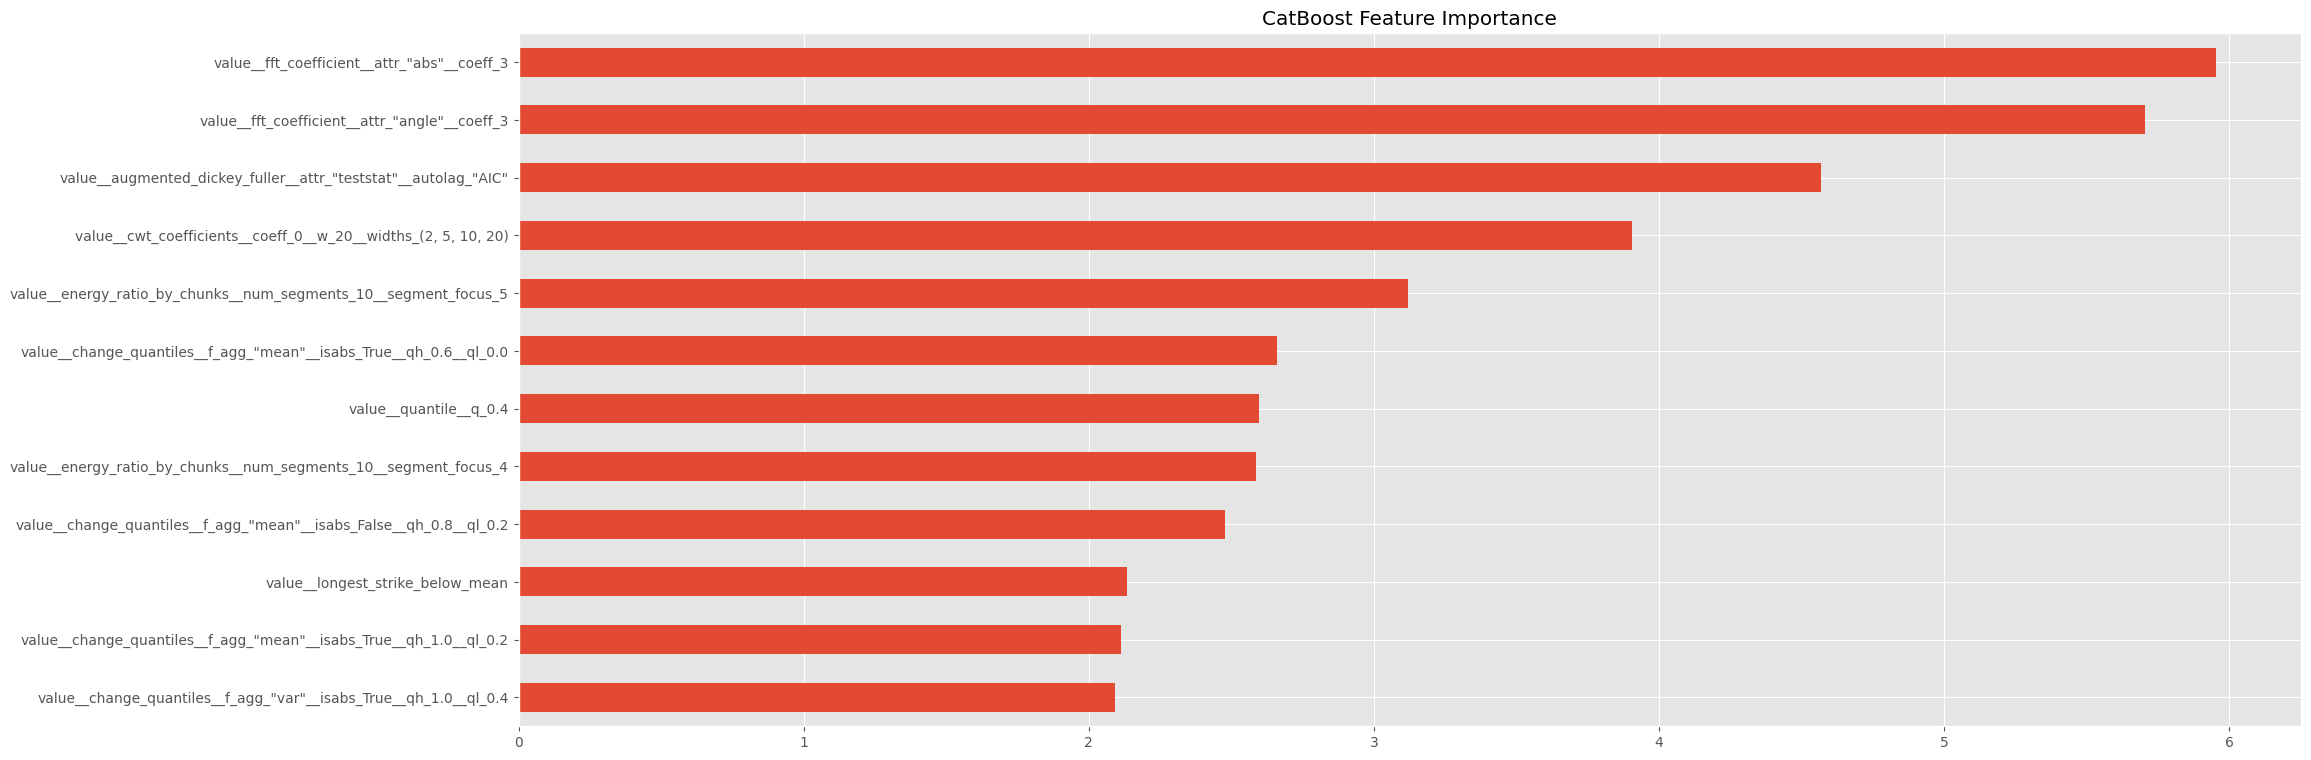

In [ ]:
feature_importance_series = pd.Series(index=catboost_model_basic_regr.feature_names_,
                                      data=catboost_model_basic_regr.feature_importances_)

# Фильтрация признаков с importance > 0
selected_features = feature_importance_series[feature_importance_series > 2]

# Сортировка и построение графика
selected_features.sort_values().plot(kind='barh')
_ = plt.title("CatBoost Feature Importance")

In [ ]:
def calc_metrics_common(y, y_pred):
  # если модель выдала 0, то искуственно заменим на 0
  # y_pred = np.where(y_pred < 0, 0, y_pred)
  msle = mean_squared_log_error(y, y_pred)
  rmse = mean_squared_error(y, y_pred, squared=False)
  mae = mean_absolute_error(y, y_pred)

  total_ape = 0
  for y_el, y_pred_el in zip(y, y_pred):
    ape = abs((y_el - y_pred_el)/y_el)
    total_ape +=ape
  mape = total_ape/len(y)*100

  return msle, rmse, mae, mape

In [ ]:
y_pred_train =  catboost_model_basic_regr.predict(X_train)
y_pred_test =  catboost_model_basic_regr.predict(X_test)


In [ ]:
calc_metrics_common(y_train, y_pred_train)

(0.00017676803095887633,
 0.08657749976936543,
 0.06644686946766815,
 1.1140628924722717)

In [ ]:
calc_metrics_common(y_test, y_pred_test)

(0.15238513115122518, 5.429599802528285, 5.429599802528285, 34.364555712204336)

In [ ]:
X_test['pred'] = y_pred_test
X_test['fact'] = y_test

In [ ]:
X_test[['fact', 'pred']]

,,fact,pred
id,2023-12-31,15.8,10.3704


In [ ]:
df['id'] = 1
df.reset_index(inplace=True)
df.head()

,index,date,y,year,month,id
0,0,2014-01-01,4,2014,1,1
1,1,2014-02-01,3,2014,2,1
2,2,2014-03-01,2,2014,3,1
3,3,2014-04-01,3,2014,4,1
4,4,2014-05-01,0,2014,5,1


In [ ]:
df_new = df[['y', 'id', 'date']].copy()

df_new.columns = ['value', 'id', 'date']

df_new

,value,id,date
0,4,1,2014-01-01
1,3,1,2014-02-01
2,2,1,2014-03-01
3,3,1,2014-04-01
4,0,1,2014-05-01
...,...,...,...
113,16,1,2023-06-01
114,25,1,2023-07-01
115,23,1,2023-08-01
116,10,1,2023-09-01


In [ ]:
df_features_new = extract_features(df_new, column_id="id", column_sort="date")

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


In [ ]:
df_features_new

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
1,1.0,0.0,1.0,1.0,897.0,10525.0,4.333333,0.076923,0.017241,6.0,...,0.552372,1.109592,3.055408,1.779282,3.083067,4.200293,4.558642,4.693744,NaN,22.714286


In [ ]:
df_features_new.shape

(1, 783)

In [ ]:
catboost_model_basic_regr.predict(df_features_new)[0]

8.783978387869828

In [ ]:
coef_monthly['pred'] = coef_monthly['yearly']* catboost_model_basic_regr.predict(df_features_new)[0]

In [ ]:
coef_monthly

,month,yearly,pred
0,1,0.593462,5.212955
1,2,0.493489,4.334797
2,3,1.077884,9.468108
3,4,1.367182,12.009299
4,5,1.258003,11.050271
5,6,1.118130,9.821628
6,7,1.385847,12.173248
7,8,1.048707,9.211819
8,9,1.020321,8.962480
9,10,0.921015,8.090178


# Выводы

Для прогнозирования будущих событий были использованы модели SARIMA, Prophet и tsfresh. Для критерия оценки использовались такие параметры MAPE, RMSE, MSE.

По результатам, все модели хорошие.  Это означает, что при необходимости они могут быть донастроены и использованы в соответствии с конкретными целями и задачами